<a href="https://colab.research.google.com/github/Alexandre77777/data_mining/blob/main/5.%20Random%20Forest/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0%20%E2%84%968.%20Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №8. Random forest**

# Задание 1. Обучите классификатор Random Forest для решения задачи бинарной классификации: для каждого человека научиться предсказывать, выживет ли он при крушении Титаника.

Ссылка на датасет: https://www.kaggle.com/c/titanic/data

## 1. Устанавливаем зависимости

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Импортируем датасет

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [3]:
# Выводим первые несколько строк обучающего набора данных
print(train_data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


## 3. Производим разведовательный анализ данных


Получим представление о данных в датасете:

In [4]:
train_data.info() #общие данные о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train_data.describe() #получим статистическую информацию по числовым данным. 891 строчка и проч. 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### для категориальных признаков

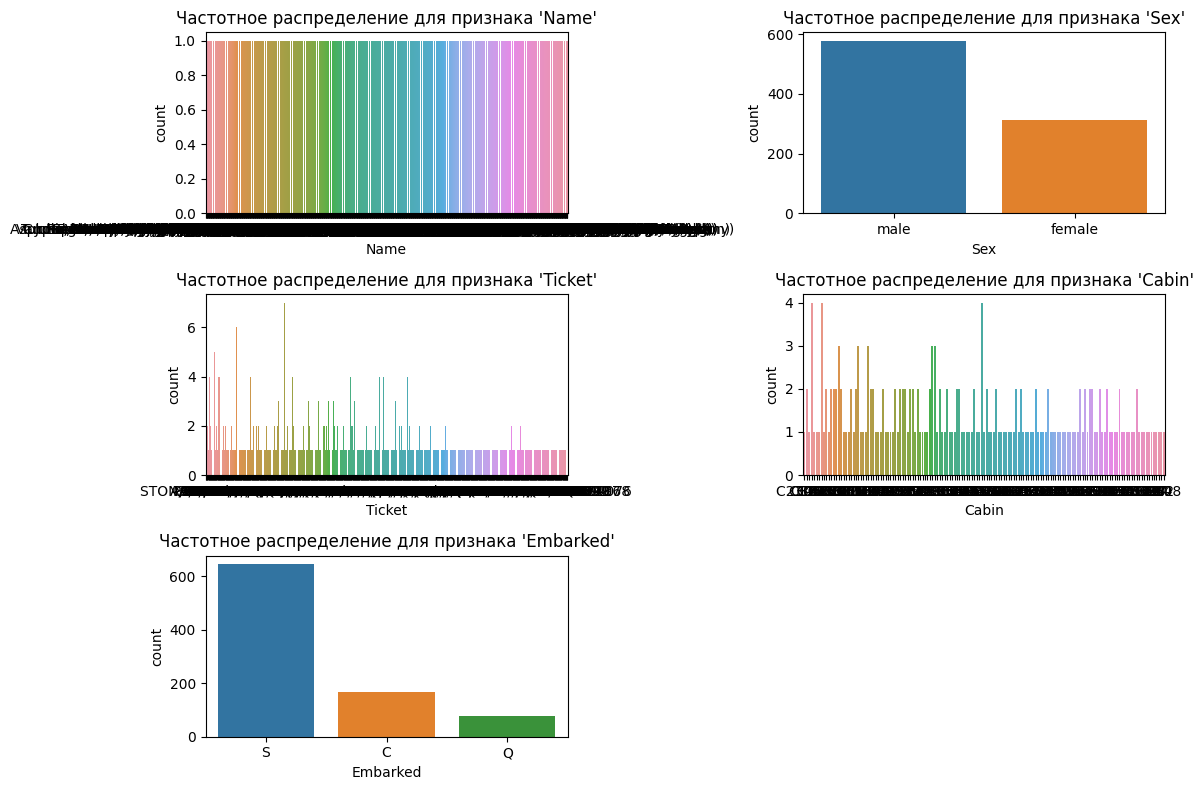

In [9]:
# Выберем только категориальные признаки
categorical_features = train_data.select_dtypes(include=['object'])

# Создадим сетку графиков для отображения гистограмм
num_plots = len(categorical_features.columns)
num_cols = 2
num_rows = (num_plots + 1) // num_cols

plt.figure(figsize=(12, 8))

for i, column in enumerate(categorical_features.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.countplot(data=train_data, x=column)
    plt.title(f"Частотное распределение для признака '{column}'")

plt.tight_layout()
plt.show()

#### посмотрим (и удивимся) на процент выживших среди мужчин и женщин и запомним эту цифру

C:\Users\Evgenie\AppData\Local\Temp\ipykernel_25216\1823736594.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Sex', y='Survived', data=train_data, ci=None)


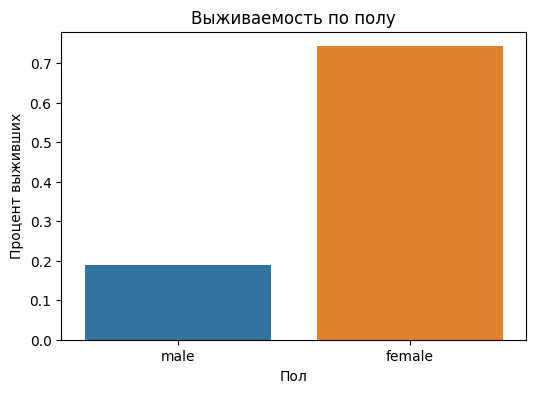

In [16]:
# Создадим график процента выживших по полу
plt.figure(figsize=(6, 4))
sns.barplot(x='Sex', y='Survived', data=train_data, ci=None)
plt.xlabel('Пол')
plt.ylabel('Процент выживших')
plt.title('Выживаемость по полу')
plt.show()

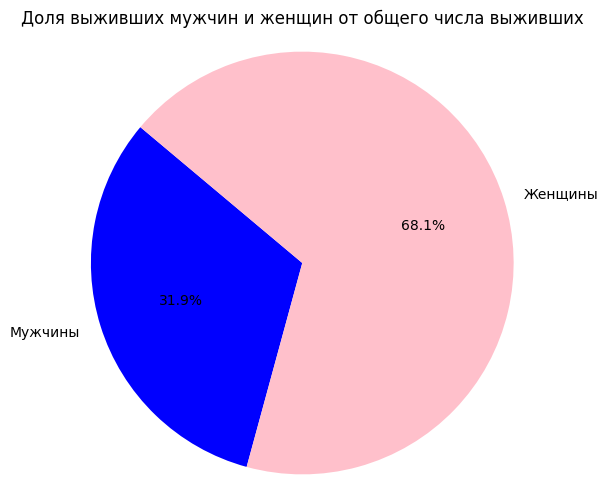

In [18]:
# Посчитаем общее число выживших
total_survived = train_data['Survived'].sum()

# Посчитаем число выживших мужчин
survived_men = train_data[(train_data['Sex'] == 'male') & (train_data['Survived'] == 1)]['Survived'].count()

# Посчитаем число выживших женщин
survived_women = train_data[(train_data['Sex'] == 'female') & (train_data['Survived'] == 1)]['Survived'].count()

# Создадим круговую диаграмму
labels = ['Мужчины', 'Женщины']
sizes = [survived_men, survived_women]
colors = ['blue', 'pink']
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Доля выживших мужчин и женщин от общего числа выживших')
plt.show()

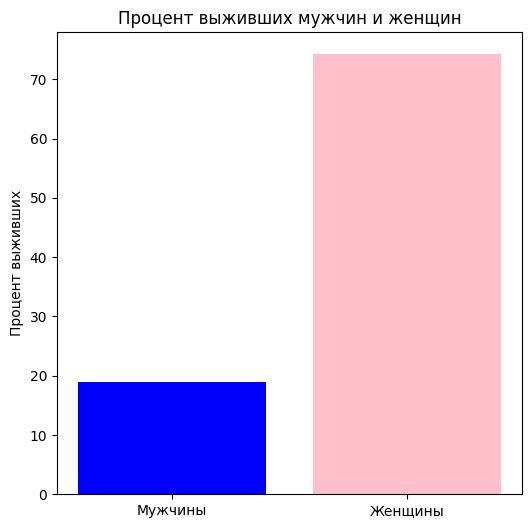

In [20]:

# Посчитаем процент выживших женщин относительно всех женщин
total_women = len(train_data[train_data['Sex'] == 'female'])
survived_women = len(train_data[(train_data['Sex'] == 'female') & (train_data['Survived'] == 1)])
percent_survived_women = (survived_women / total_women) * 100

# Посчитаем процент выживших мужчин относительно всех мужчин
total_men = len(train_data[train_data['Sex'] == 'male'])
survived_men = len(train_data[(train_data['Sex'] == 'male') & (train_data['Survived'] == 1)])
percent_survived_men = (survived_men / total_men) * 100

# Создадим график с двумя столбцами для процентов выживших мужчин и женщин
labels = ['Мужчины', 'Женщины']
percent_survived = [percent_survived_men, percent_survived_women]
colors = ['blue', 'pink']
plt.figure(figsize=(6, 6))
plt.bar(labels, percent_survived, color=colors)
plt.ylabel('Процент выживших')
plt.title('Процент выживших мужчин и женщин')
plt.show()

In [36]:
print(f"Количество выживших женщин: {survived_women} от общего числа женщин {total_women}")
print(f"Процент выживших мужчин: {survived_men} от общего числа мужчин {total_men}")

Количество выживших женщин: 233 от общего числа женщин 314
Процент выживших мужчин: 109 от общего числа мужчин 577


In [11]:
# Получим уникальные значения признака 'Cabin' и выведем их
unique_cabins = train_data['Cabin'].unique()
print("Уникальные значения признака 'Cabin':")
for cabin in unique_cabins:
    print(cabin)

Уникальные значения признака 'Cabin':
nan
C85
C123
E46
G6
C103
D56
A6
C23 C25 C27
B78
D33
B30
C52
B28
C83
F33
F G73
E31
A5
D10 D12
D26
C110
B58 B60
E101
F E69
D47
B86
F2
C2
E33
B19
A7
C49
F4
A32
B4
B80
A31
D36
D15
C93
C78
D35
C87
B77
E67
B94
C125
C99
C118
D7
A19
B49
D
C22 C26
C106
C65
E36
C54
B57 B59 B63 B66
C7
E34
C32
B18
C124
C91
E40
T
C128
D37
B35
E50
C82
B96 B98
E10
E44
A34
C104
C111
C92
E38
D21
E12
E63
A14
B37
C30
D20
B79
E25
D46
B73
C95
B38
B39
B22
C86
C70
A16
C101
C68
A10
E68
B41
A20
D19
D50
D9
A23
B50
A26
D48
E58
C126
B71
B51 B53 B55
D49
B5
B20
F G63
C62 C64
E24
C90
C45
E8
B101
D45
C46
D30
E121
D11
E77
F38
B3
D6
B82 B84
D17
A36
B102
B69
E49
C47
D28
E17
A24
C50
B42
C148


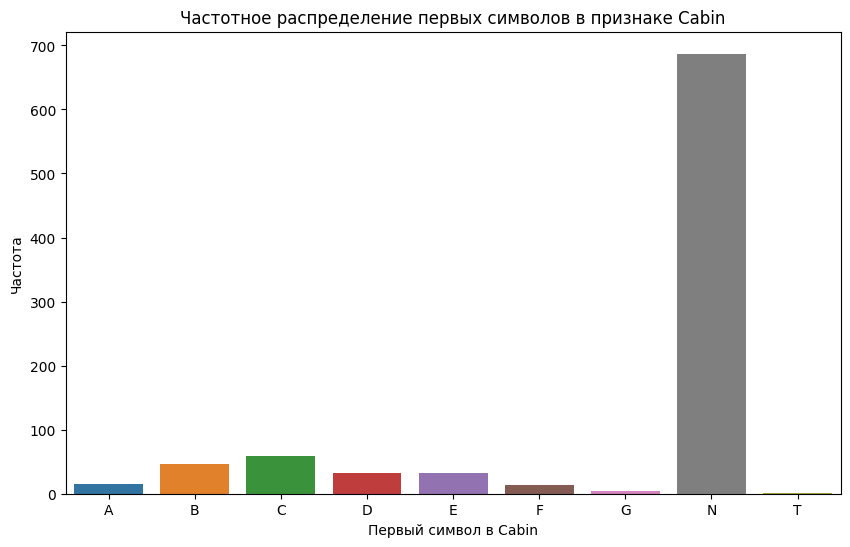

In [13]:
# Заполним отсутствующие значения в столбце 'Cabin' символом 'N' (как "Unknown")
train_data['Cabin'].fillna('N', inplace=True)

# Извлечем первый символ из признака 'Cabin'
train_data['Cabin_First_Letter'] = train_data['Cabin'].str[0]

# Создадим сетку графиков для отображения гистограмм
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='Cabin_First_Letter', order=sorted(train_data['Cabin_First_Letter'].unique()))
plt.xlabel('Первый символ в Cabin')
plt.ylabel('Частота')
plt.title('Частотное распределение первых символов в признаке Cabin')

plt.show()

#### если бы nan не было бы 70%, то был бы интересный анализ. уже сейчас видно, что пассажирам категории А только в 50% случаев выжили, а вот категории D - 75%. Впрочем, думаю кабины высоко коррелируют со стоимостью, поэтому см. ниже.

In [14]:
# Извлечем первую букву из признака 'Cabin'
train_data['Cabin_First_Letter'] = train_data['Cabin'].str[0]

# Создадим сводную таблицу для подсчета количества выживших и погибших в каждой группе
survival_by_cabin_letter = train_data.groupby('Cabin_First_Letter')['Survived'].value_counts().unstack()
survival_by_cabin_letter.fillna(0, inplace=True)  # Заполним отсутствующие значения нулями

# Выведем результат
print("Выживаемость в зависимости от первой буквы в каюте:")
print(survival_by_cabin_letter)

Выживаемость в зависимости от первой буквы в каюте:
Survived                0      1
Cabin_First_Letter              
A                     8.0    7.0
B                    12.0   35.0
C                    24.0   35.0
D                     8.0   25.0
E                     8.0   24.0
F                     5.0    8.0
G                     2.0    2.0
N                   481.0  206.0
T                     1.0    0.0


#### для числовых признаков

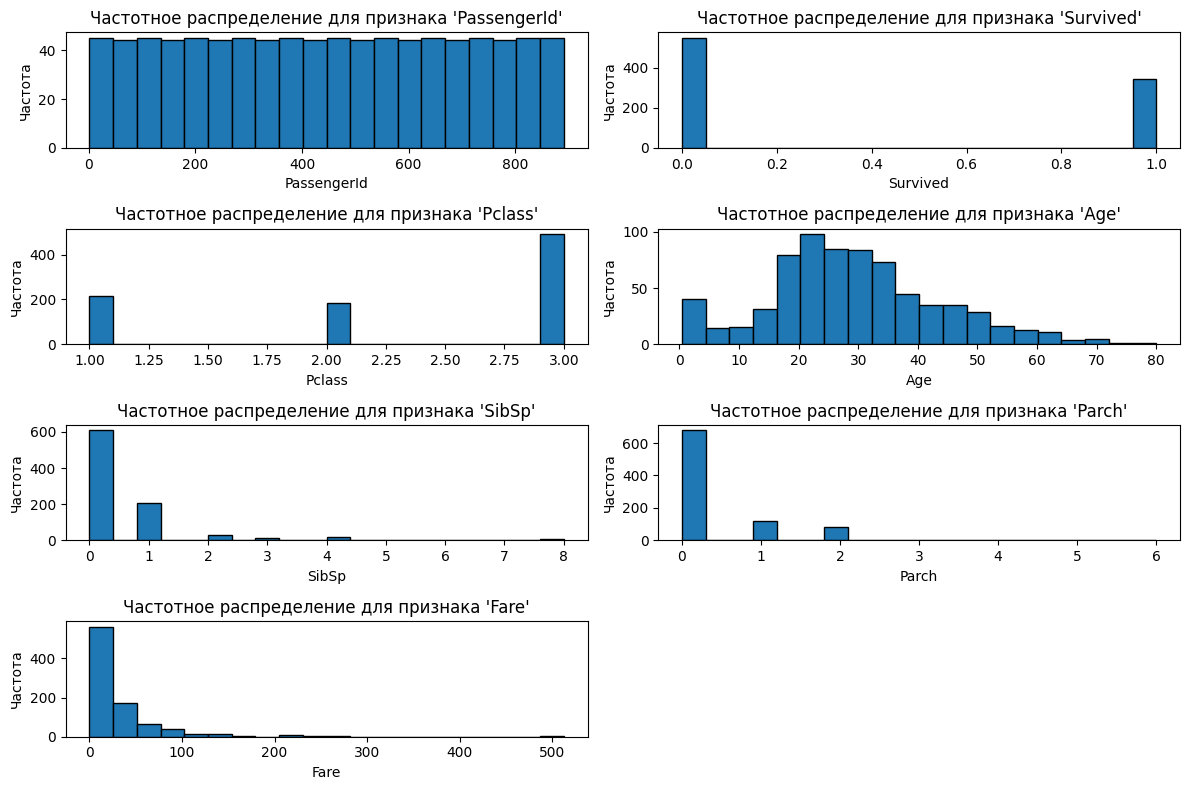

In [10]:
numerical_features = train_data.select_dtypes(include=['int64', 'float64'])

# Создадим сетку графиков для отображения гистограмм
num_plots = len(numerical_features.columns)
num_cols = 2
num_rows = (num_plots + 1) // num_cols

plt.figure(figsize=(12, 8))

for i, column in enumerate(numerical_features.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.hist(train_data[column], bins=20, edgecolor='k')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.title(f"Частотное распределение для признака '{column}'")

plt.tight_layout()
plt.show()

#### Посмотрим (и порадуемся, что я, кажется прав), что есть корреляция между стоимостью и выживаемостью

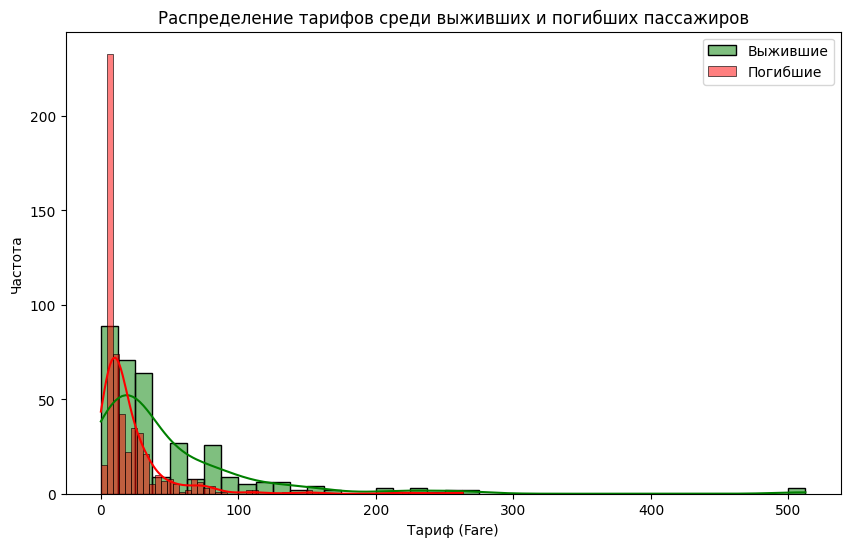

In [15]:
# Создадим гистограммы тарифов среди выживших и погибших пассажиров
plt.figure(figsize=(10, 6))
sns.histplot(train_data[train_data['Survived'] == 1]['Fare'], kde=True, color='g', label='Выжившие')
sns.histplot(train_data[train_data['Survived'] == 0]['Fare'], kde=True, color='r', label='Погибшие')
plt.xlabel('Тариф (Fare)')
plt.ylabel('Частота')
plt.title('Распределение тарифов среди выживших и погибших пассажиров')
plt.legend()
plt.show()

#### Парадокс выживаемости можно было объяснить и средним возрастом... Либо одной волшебной исторической байкой: Мало того, рыцарство мужчин на "Титанике" имеет простое объяснение: капитан Эдвард Смит пригрозил застрелить любого, кто попробует опередить женщин и детей. Поэтому на "Титанике" спаслись 73,3% женщин, 50,4% детей и только 20,7% мужчин. 

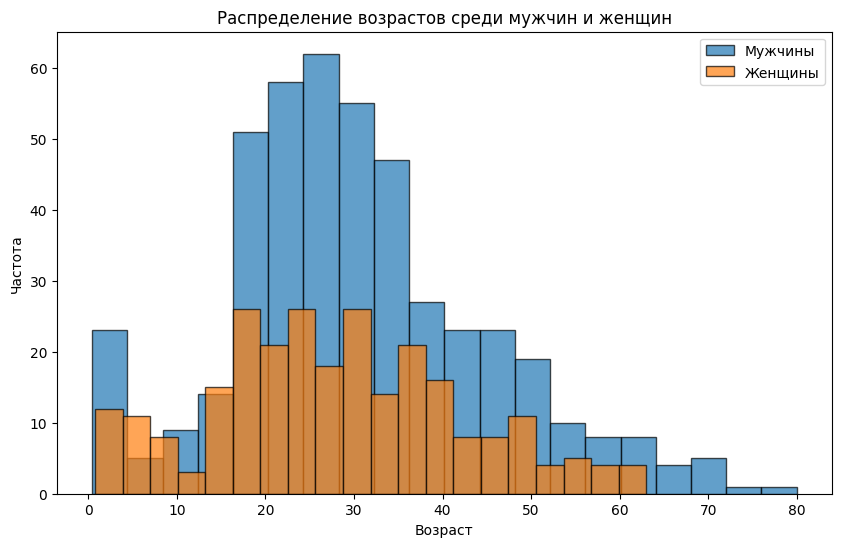

In [26]:
# Создадим гистограммы возрастов для мужчин и женщин
plt.figure(figsize=(10, 6))
plt.hist(train_data[train_data['Sex'] == 'male']['Age'].dropna(), bins=20, edgecolor='k', label='Мужчины', alpha=0.7)
plt.hist(train_data[train_data['Sex'] == 'female']['Age'].dropna(), bins=20, edgecolor='k', label='Женщины', alpha=0.7)
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распределение возрастов среди мужчин и женщин')
plt.legend()
plt.show()

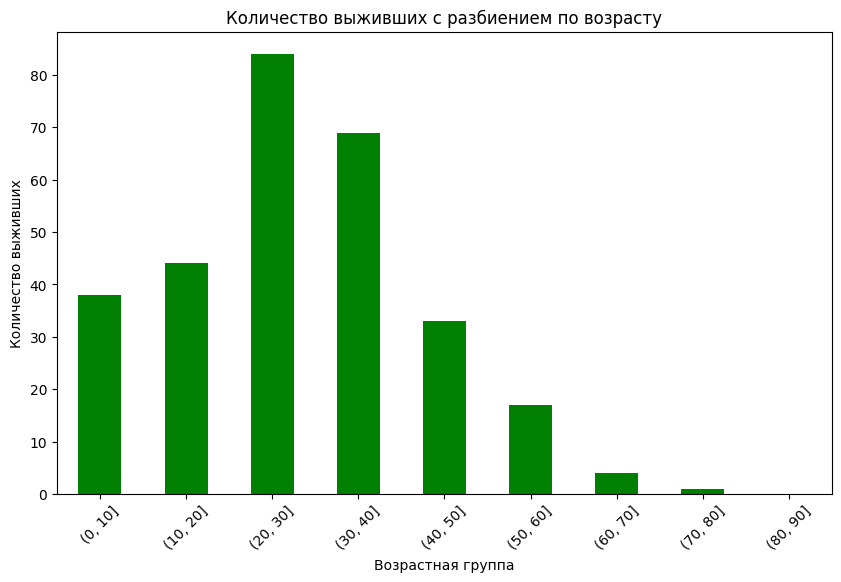

In [23]:
# Создадим разбиение возрастов по 10 лет
age_bins = range(0, 91, 10)  # Возраста 0-10, 10-20, и т. д.

# Создадим категорию "AgeGroup" для каждого пассажира на основе его возраста
train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=age_bins)

# Посчитаем количество выживших в каждой возрастной группе
survival_counts = train_data[train_data['Survived'] == 1]['AgeGroup'].value_counts().sort_index()

# Создадим столбчатую диаграмму
plt.figure(figsize=(10, 6))
survival_counts.plot(kind='bar', color='green')
plt.xlabel('Возрастная группа')
plt.ylabel('Количество выживших')
plt.title('Количество выживших с разбиением по возрасту')
plt.xticks(rotation=45)
plt.show()

In [25]:
# Посчитаем общее количество лиц до 18 лет
total_under_18 = len(train_data[train_data['Age'] <= 18])

# Посчитаем количество выживших до 18 лет
survived_under_18 = len(train_data[(train_data['Age'] <= 18) & (train_data['Survived'] == 1)])

# Вычислим процент выживших до 18 лет от общего числа лиц до 18 лет
percent_survived_under_18 = (survived_under_18 / total_under_18) * 100

print(f"Количество выживших до 18 лет: {survived_under_18}")
print(f"Процент выживших до 18 лет от общего числа лиц до 18 лет: {percent_survived_under_18:.2f}%")

Количество выживших до 18 лет: 70
Процент выживших до 18 лет от общего числа лиц до 18 лет: 50.36%


In [33]:
# Посчитаем общее количество лиц после 18 лет
total_up_18 = len(train_data[train_data['Age'] > 18])

# Посчитаем количество выживших после 18 лет
survived_up_18 = len(train_data[(train_data['Age'] > 18) & (train_data['Survived'] == 1)])

# Вычислим процент выживших после 18 лет от общего числа лиц до 18 лет
percent_survived_up_18 = (survived_up_18 / total_up_18) * 100

print(f"Количество выживших после 18 лет: {survived_up_18}")
print(f"Процент выживших после 18 лет от общего числа лиц после 18 лет: {percent_survived_up_18:.2f}%")

Количество выживших после 18 лет: 220
Процент выживших после 18 лет от общего числа лиц после 18 лет: 38.26%


## 4. Сформируем обучающую и тестовую выборки:


In [37]:
from sklearn.model_selection import train_test_split

# Определим целевую переменную (target) и признаки (features)
target = train_data['Survived']
features = train_data.drop(['Survived'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## 5. Feature Engineering

Поработаем с признаками, выделим важные, изменим форму их представления (при надобности)

In [4]:
age_bins = [0, 12, 18, 30, 50, float('inf')]  # Границы групп, включая "inf" для старших пассажиров

# Определим метки для каждой возрастной группы
age_labels = ['Дети', 'Подростки', 'Средний возраст', 'От 30 до 50', 'Больше 50']

# Создадим новый столбец 'AgeGroup', который будет содержать информацию о возрастных группах
train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=age_bins, labels=age_labels, right=False)

train_data = pd.get_dummies(train_data, columns=['AgeGroup'], prefix='AgeGroup')


In [5]:
from sklearn.preprocessing import LabelEncoder

# Создайте объект LabelEncoder
label_encoder = LabelEncoder()

# Примените Label Encoding к столбцу 'Sex'
train_data['Sex'] = label_encoder.fit_transform(train_data['Sex'])

In [6]:
# Определим границы категорий для признака 'Fare'
fare_bins = [0, 10, 30, 60, 100, float('inf')]  # Границы категорий, включая "inf" для самых дорогих билетов

# Определим метки для каждой категории
fare_labels = ['Дешево', 'Умеренно', 'Средне', 'Дорого', 'Очень дорого']

# Создадим новый столбец 'FareCategory', который будет содержать информацию о категории стоимости билета
train_data['FareCategory'] = pd.cut(train_data['Fare'], bins=fare_bins, labels=fare_labels, right=False)

# Теперь у вас есть столбец 'FareCategory', который указывает на категории стоимости билетов.

# Оценим корреляцию между 'FareCategory' и 'Survived'
correlation = train_data[['FareCategory', 'Survived']].groupby('FareCategory').mean()
print(correlation)

train_data = pd.get_dummies(train_data, columns=['FareCategory'], prefix='FareCategory')

              Survived
FareCategory          
Дешево        0.199405
Умеренно      0.425397
Средне        0.500000
Дорого        0.623188
Очень дорого  0.735849


In [7]:
from sklearn.model_selection import train_test_split


# Выберем только созданные нами признаки
selected_features = ['AgeGroup_Дети', 'AgeGroup_Подростки', 'AgeGroup_Средний возраст', 'AgeGroup_От 30 до 50', 'AgeGroup_Больше 50', 'FareCategory_Дешево', 'FareCategory_Умеренно', 'FareCategory_Средне', 'FareCategory_Дорого', 'FareCategory_Очень дорого', 'Sex']

selected_data = train_data[selected_features]

target = train_data['Survived']

X_train, X_val, y_train, y_val = train_test_split(selected_data, target, test_size=0.2, random_state=42)

## 6. Построение базовой модели:

In [55]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

## 7. Оценка точности модели:

### 7.1. Напишите функцию, принимающую на вход аргументы y_pred, y_test и выполняющую визуализацию матрицы ошибок и отчета классификации

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix_and_report(y_pred, y_test):

    cm = confusion_matrix(y_test, y_pred)


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False, annot_kws={"size": 16})
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.title('Матрица ошибок')
    plt.show()

  
    report = classification_report(y_test, y_pred)
    print("Отчет классификации:")
    print(report)

### 7.2. Оцените точность модели:

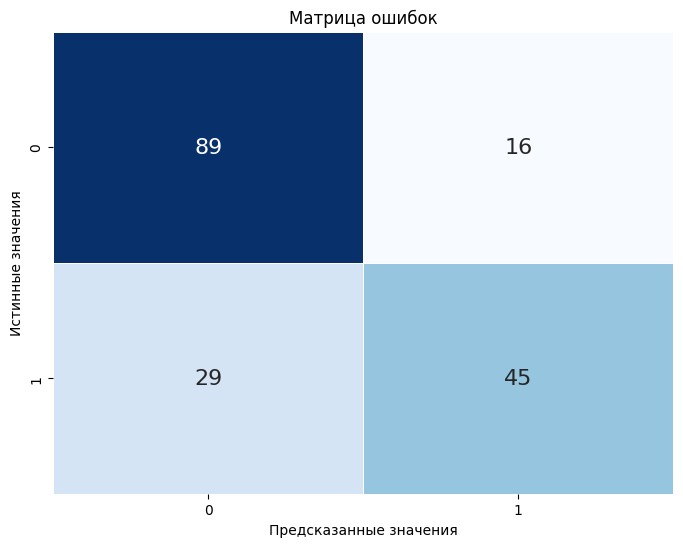

Отчет классификации:
              precision    recall  f1-score   support

           0       0.75      0.85      0.80       105
           1       0.74      0.61      0.67        74

    accuracy                           0.75       179
   macro avg       0.75      0.73      0.73       179
weighted avg       0.75      0.75      0.74       179



In [59]:
plot_confusion_matrix_and_report(y_pred, y_test)

## 8. Тюнинг гиперпараметров модели:

RandomSearchCV

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

# распределение для гиперпараметров
param_dist = {
    'n_estimators': scipy.stats.randint(1, 200),
    'max_depth': scipy.stats.randint(10, 100),
    'min_samples_split': scipy.stats.randint(2, 20),
    'min_samples_leaf': scipy.stats.randint(1, 10)
}

#экземпляр модели RandomForestClassifier
rf = RandomForestClassifier()

#объект RandomizedSearchCV с параметрами
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)

#поиск наилучших гиперпараметров на обучающих данных
random_search.fit(X_train, y_train)

# наилучшие гиперпараметры и результат
best_params = random_search.best_params_
best_score = random_search.best_score_

# Выведите наилучшие гиперпараметры и результат
print(f'Наилучшие гиперпараметры: {best_params}')
best_score_percent = best_score * 100
print(f'Наилучший результат: {best_score_percent:.2f}%')


Наилучшие гиперпараметры: {'max_depth': 14, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 28}
Наилучший результат: 79.63%


GridSearchCV

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10,25, 50, 75, 100, 150],
    'max_depth': [5,10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6]
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_score_percent = best_score * 100
print(f'Наилучший результат {best_score_percent:.2f}% с параметрами {best_params}')

Наилучший результат 79.77% с параметрами {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 10}


## 9. Оценка лучшей модели:

In [72]:
from sklearn.ensemble import RandomForestClassifier


rf_params = {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 10}

custom_rf_model = RandomForestClassifier(**rf_params)


custom_rf_model.fit(X_train, y_train)



RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=10)

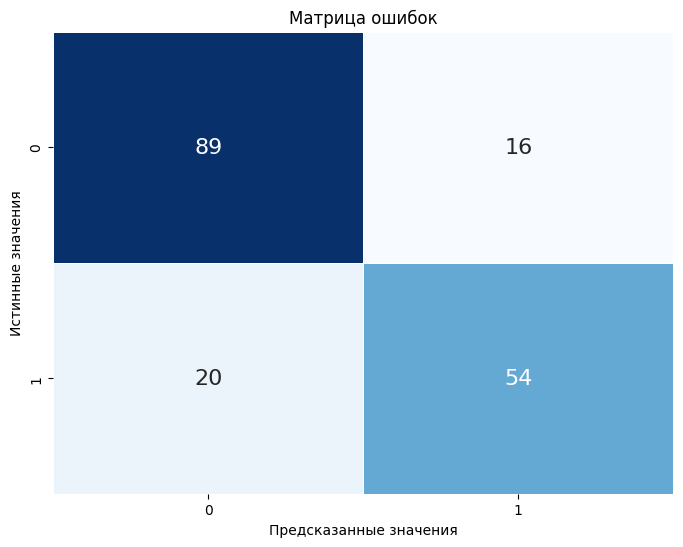

Отчет классификации:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       105
           1       0.77      0.73      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [74]:
y_pred = custom_rf_model.predict(X_val)

plot_confusion_matrix_and_report(y_pred, y_test)

# Задание 2. Решите задачу из предыдущего пункта используя другие, ранее пройденные классификаторы. Сравните их точность предсказания с Random Forest

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#  модель DecisionTreeClassifier
tree_model = DecisionTreeClassifier()

# сетка гиперпараметров
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None,3, 5,10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4,8],
    'max_features': ['sqrt', 'log2',None],
}


grid_search_tree = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='accuracy')


grid_search_tree.fit(X_train, y_train)


best_params_tree = grid_search_tree.best_params_
best_score_tree = grid_search_tree.best_score_


best_tree_model = DecisionTreeClassifier(**best_params_tree)
best_tree_model.fit(X_train, y_train)


print(f'Наилучшие гиперпараметры для DecisionTreeClassifier: {best_params_tree}')
best_score_tree_percent = best_score_tree * 100
print(f'Наилучший результат: {best_score_tree_percent:.2f}%')


Наилучшие гиперпараметры для DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2}
Наилучший результат: 79.77%


# Задание 2.1*. Реализуйте функцию, для взаимодействия с обученной Вами моделью

* Функция должна принимать на вход обученную модель классификатора;

* После вызова функции, у пользователя через консоль запрашиваются значения признаков. При запросе значений нужно вывести пояснения о типе и диапазоне возможных значений. Также реализуйте обработку исключений;

* После ввода значений для всех признаков в консоль, выводится результат работы классификатора.

In [ ]:
# ???



# Задание 3. Решите задачу регрессии, используя [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

* Для выполнения данного задания можете использовать **любой датасет**



In [ ]:
# Ваш код